# Reproducing astroNN distance prediction result on Gaia TGAS DR1/ Gaia DR2

This notebook will walk you through how to reproduce astroNN gaia distance prediction result as claimed by astroNN author.

This notebook may required `mw_plot` which is decribed at https://github.com/henrysky/milkyway_plot

### To save time, you can scroll down and use my trained model with ID: `astroNN_0422_run001`

## This notebook is no longer being maintained. Moreover, starting from 28 May 2018, astroNN defaulted to use Gaia DR2 instead of DR1 to compile dataset. So if you want to compile the dataset used here, please use astroNN commited before 28 May 2018

In [2]:
from astroNN.apogee import allstar, visit_spectra
from astropy.io import fits
from astroNN.datasets import xmatch
import numpy as np
from astroNN.gaia import tgas_load, mag_to_fakemag
from astroNN.apogee.chips import apogee_continuum, gap_delete
from astroNN.nn.losses import mean_absolute_percentage_error
import time

# Setup continuum normalization
target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]
def apstar_normalization(spectra, spectra_err, _spec_mask):
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=14, bitmask=_spec_mask)

# Load Gaia TGAS DR1, only load parallax > 0 and parallax error < 20%
output = tgas_load(cuts=0.2)

# Load Apogee allstar DR14
allstar_data = fits.open(allstar(dr=14))

# We only want APOGEE spectra from APO 2.5m telescope and spectra without any starflag
good_idx = [(allstar_data[1].data['telescope']=='apo25m')&(allstar_data[1].data['starflag']==0)]

# We only want APOGEE spectra from APO 2.5m telescope and spectra without any starflag
idx_1, idx_2, sep = xmatch(allstar_data[1].data['RA'][good_idx], output['ra'], colRA1=allstar_data[1].data['RA'][good_idx], 
                           colDec1=allstar_data[1].data['DEC'][good_idx], colRA2=output['ra'], colDec2=output['dec'], 
                           colpmRA2=output['pmra'], colpmDec2=output['pmdec'], swap=False)

print('Total number of spectra in training set: ', idx_1.shape)

delete_list = []

# pre-allocating spectra array
spec = np.zeros((idx_1.shape[0], 7514))

start_time = time.time()
for counter, i in enumerate(idx_1):
    ap_path = visit_spectra(dr=14, apogee=allstar_data[1].data['APOGEE_ID'][good_idx][i],location=allstar_data[1].data['LOCATION_ID'][good_idx][i], verbose=0)
    apstar_file = fits.open(ap_path)
    # we only want combined spectra
    nvisits = apstar_file[0].header['NVISITS']
    if nvisits == 1:
        _spec = apstar_file[1].data
        _spec_err = apstar_file[2].data
        _spec_mask = apstar_file[3].data
    else:
        _spec = apstar_file[1].data[1]
        _spec_err = apstar_file[2].data[1]
        _spec_mask = apstar_file[3].data[1]
    _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)
    
    spec[counter] =  _spec
    if counter % 100 == 0:
        print(f'Completed {counter} of {idx_1.shape[0]}, {(time.time() - start_time):.{2}f}s elapsed')

idx_1=np.delete(idx_1, delete_list)
idx_2=np.delete(idx_2, delete_list)

kmag = allstar_data[1].data['K'][good_idx][idx_1]
fakemag, fakemag_err = mag_to_fakemag(kmag, output['parallax'][idx_2], output['parallax_err'][idx_2])

# save all the reducted data
np.save('spec.npy', spec)
np.save('fakemag.npy', fakemag)
np.save('fakemag_err.npy', fakemag_err)

E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-000.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-001.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-002.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-003.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-004.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-005.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-006.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-007.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-008.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-009.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-010.fits was found!
E:\gaia_mirror\Gaia/gdr1/tgas_source/fits/TgasSource_000-000-011.fits was found!
E:\gaia_mirror\Gaia/gdr1/tga

## Load the reduced data and train a neural network

#### You can save time by using the neural network trained on 22 April 2018

In [ ]:
# load reduced data
spec = np.load('spec.npy')
fakemag = np.load('fakemag.npy')
fakemag_err = np.load('fakemag_err.npy')

# Train a neural Network and save
from astroNN.models import ApogeeBCNN
bcnn = ApogeeBCNN()
bcnn.max_epochs = 60
bcnn.dropout_rate = 0.3
bcnn.num_hidden = [128, 64]
bcnn.l2 = 1e-5
bcnn.targename=['fakemag']  # corectly set output neurone representation which is a good practice in astroNN
bcnn.autosave=True  # autosave after finising training
bcnn.train(spec, fakemag, labels_err=fakemag_err)

## Compile Testing Set and do Inference

#### You can save time by using the result directly by reading `_astronn_dist.npy` and `_astronn_dist_err.npy`

Since we want data-driven distance prediction for the whole APOGEE DR14, we need to compile a data set so we can setup inference with neural network easily

In [ ]:
import numpy as np
import time
import h5py
from astropy.io import fits

from astroNN.apogee import allstar, visit_spectra
from astroNN.datasets import xmatch
from astroNN.gaia import tgas_load, mag_to_fakemag
from astroNN.apogee.chips import apogee_continuum, gap_delete
from astroNN.nn.losses import mean_absolute_percentage_error
from astroNN.datasets import load_apogee_distances

# load apogee distances data, we dont want cuts because we dont really use it, or you can cut bad prediction later
aRA, aDEC, metrics_array, metrics_err_array = load_apogee_distances(dr=14, metric='distance', cuts=False)

# Setup continuum normalization
target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]
def apstar_normalization(spectra, spectra_err, _spec_mask):
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=14, bitmask=_spec_mask)

# Load Gaia TGAS DR1, only load parallax > 0 and parallax error < 20%
output = tgas_load(cuts=0.2)
allstar_data = fits.open(allstar(dr=14))

# We only want APOGEE spectra from APO 2.5m telescope, spectra without any starflag and spectra with SNR higher than 50
good_idx = [(allstar_data[1].data['telescope']=='apo25m')&(allstar_data[1].data['starflag']==0)&
            (allstar_data[1].data['SNR']>50)]

loop_var = np.arange(allstar_data[1].data['telescope'].shape[0])[good_idx]

# pre-allocating spectra array
spec = np.zeros((np.sum(good_idx), 7514), dtype=np.float32)

start_time = time.time()
for counter, i in enumerate(loop_var):
    ap_path = visit_spectra(dr=14, apogee=allstar_data[1].data['APOGEE_ID'][i], 
                            location=allstar_data[1].data['LOCATION_ID'][i], verbose=0)
    if ap_path is False:
        pass
    else:
        apstar_file = fits.open(ap_path)
        # we only want combined spectra
        nvisits = apstar_file[0].header['NVISITS']
        if nvisits == 1:
            _spec = apstar_file[1].data
            _spec_err = apstar_file[2].data
            _spec_mask = apstar_file[3].data
        else:
            _spec = apstar_file[1].data[1]
            _spec_err = apstar_file[2].data[1]
            _spec_mask = apstar_file[3].data[1]

        _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)

        spec[counter] =  _spec
    if counter % 100 == 0:
        print(f'Completed {counter} of {np.sum(good_idx)}, {(time.time() - start_time):.{2}f}s elapsed')

# Create the testing set file
h5f = h5py.File(f'apogee4gaia_dr2.h5', 'w')
h5f.create_dataset('RA', data=allstar_data[1].data['RA'][good_idx])
h5f.create_dataset('DEC', data=allstar_data[1].data['DEC'][good_idx])
h5f.create_dataset('K', data=allstar_data[1].data['K'][good_idx])
h5f.create_dataset('apogee_dist', data=metrics_array[good_idx])
h5f.create_dataset('apogee_dist_err', data=metrics_err_array[good_idx])
h5f.create_dataset('spectra', data=spec)
h5f.create_dataset('teff', data=allstar_data[1].data['PARAM'][good_idx][:,0])
h5f.create_dataset('SNR', data=allstar_data[1].data['SNR'][good_idx])
h5f.create_dataset('MH', data=allstar_data[1].data['M_H'][good_idx])
h5f.create_dataset('FeH', data=allstar_data[1].data['Fe_H'][good_idx])
h5f.create_dataset('logg', data=allstar_data[1].data['LOGG'][good_idx])
h5f.close()

In [ ]:
from astroNN.models import load_folder
from astroNN.gaia import fakemag_to_pc
import h5py
import numpy as np

bcnn = load_folder('astroNN_0422_run001')

h5f = h5py.File(f'apogee4gaia_dr2.h5', 'r')
spec = np.array(h5f['spectra'])
Kmag = np.array(h5f['K'])
adpc = np.array(h5f['apogee_dist'])
adpc_err = np.array(h5f['apogee_dist_err'])

# prediction and its uncertainty, they are fakemag and fakemag uncertainty in this case
pred, pred_err = bcnn.test(spec)

# convert fakemag and propagated uncertainty to distances
astronn_pc, astronn_pc_err = fakemag_to_pc(pred[:, 0], Kmag, pred_err['total'][:, 0])

# setup the distances so we can check whether neural network is good on 25 April when Gaia DR2 release
np.save('_astronn_dist.npy', pred)
np.save('_astronn_dist_err.npy', pred_err['total'])

## Comparing Bayesian Neural Network to Gaia DR2

In [4]:
from astroNN.gaia import fakemag_to_pc
import h5py
import numpy as np
from astroNN.datasets import xmatch
from astroNN.nn.numpy import mean_absolute_percentage_error
from astroNN.gaia import gaiadr2_parallax

pred = np.load('_astronn_dist.npy')
pred_err = np.load('_astronn_dist_err.npy')

h5f = h5py.File(f'apogee4gaia_dr2.h5', 'r')
adpc = np.array(h5f['apogee_dist'])
apogeeRA = np.array(h5f['RA'])
apogeeDEC = np.array(h5f['DEC'])
adpc_err = np.array(h5f['apogee_dist_err'])
Kmag = np.array(h5f['K'], dtype=np.float32)
astronn_pc, astronn_pc_err = fakemag_to_pc(pred[:, 0], Kmag, pred_err[:, 0])
astroNN_uncerpre = astronn_pc_err.value / (astronn_pc.value + 1e-8)

# To load Gaia DR2 - APOGEE DR14 matches, indices corresponds to APOGEE allstar DR14 file
ted_ra, ted_dec, ted_pc, ted_pc_err = gaiadr2_parallax(cuts=0.2, keepdims=False)

good_idx_astroNN = [(astroNN_uncerpre < 0.2) & (astronn_pc.value > 0.)]
idx_1, idx_2, sep = xmatch(apogeeRA[good_idx_astroNN], ted_ra, colRA1=apogeeRA[good_idx_astroNN],
                           colDec1=apogeeDEC[good_idx_astroNN], colRA2=ted_ra,
                           colDec2=ted_dec, swap=False)

astroNNXM = astronn_pc[good_idx_astroNN][idx_1].value
gaiaXM = (1000/ted_pc)[idx_2]

mape_dr2_apogeedist = mean_absolute_percentage_error(astroNNXM, gaiaXM)

print(f'Mean Absolute Precentage Error: {mape_dr2_apogeedist:.{2}f}% for {astroNNXM.shape[0]} spectra at 20% NN uncertainty cuts')

This is Gaia DR2 - APOGEE DR14 matched parallax, RA DEC in J2000, parallax in mas
Mean Absolute Precentage Error: 14.48% for 57169 spectra at 20% NN uncertainty cuts


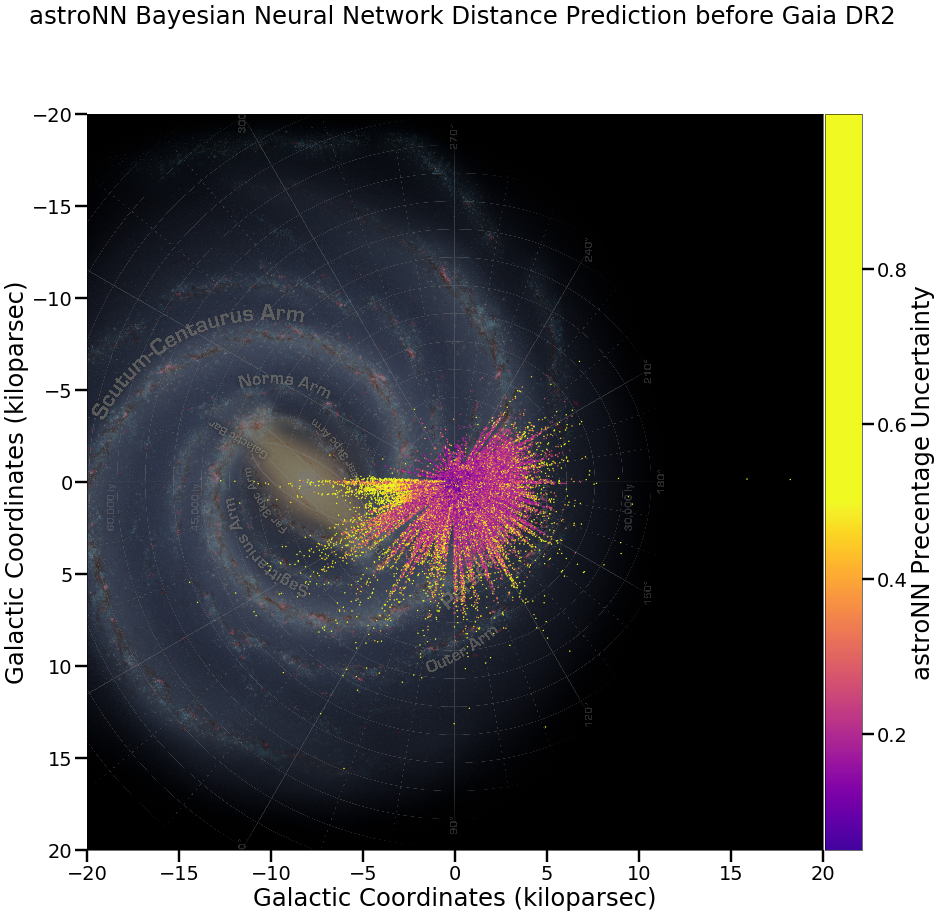

In [5]:
from astroNN.gaia import fakemag_to_pc
from mw_plot import MWPlot
from astroNN.gaia import tgas_load
from astropy import units as  u
import astropy.coordinates as apycoords
from astropy.io import fits
import h5py
import numpy as np

pred = np.load('_astronn_dist.npy')
pred_err = np.load('_astronn_dist_err.npy')

h5f = h5py.File(f'apogee4gaia_dr2.h5', 'r')
adpc = np.array(h5f['apogee_dist'])
apogeeRA = np.array(h5f['RA'])
apogeeDEC = np.array(h5f['DEC'])
adpc_err = np.array(h5f['apogee_dist_err'])

Kmag = np.array(h5f['K'], dtype=np.float32)
astronn_pc, astronn_pc_err = fakemag_to_pc(pred[:, 0], Kmag, pred_err[:, 0])
astroNN_uncerpre = astronn_pc_err.value / (astronn_pc.value + 1e-8)
good_idx_astroNN = [(astroNN_uncerpre < 1.0) & (astronn_pc.value > 0.)]

# use astropy coordinates tranformation
c = apycoords.SkyCoord(ra=apogeeRA[good_idx_astroNN]*u.deg, dec=apogeeDEC[good_idx_astroNN]*u.deg, 
                       distance=astronn_pc[good_idx_astroNN], frame='icrs')

# setup a MWPlot instance
# use galactic coordinates because Gaia observations are from Earth
plot_instance = MWPlot(radius=20*u.kpc, unit=u.kpc, coord='galactic')

plot_instance.s = 1.0  # make the scatter points bigger
plot_instance.dpi = 50 # increase this to increase image quality
plot_instance.imalpha = 0.5
plot_instance.cmap = 'plasma'
plot_instance.clim = (0, 0.5)
# plot, need to flip the sign of x because astropy is left-handed but mw_plot is right-handed
plot_instance.mw_plot(-c.galactic.cartesian.x, c.galactic.cartesian.y, [astroNN_uncerpre[good_idx_astroNN], 'astroNN Precentage Uncertainty'],
                   'astroNN Bayesian Neural Network Distance Prediction before Gaia DR2')

# Save the figure
# plot_instance.savefig(file='gaia_dr2_astronn.png')

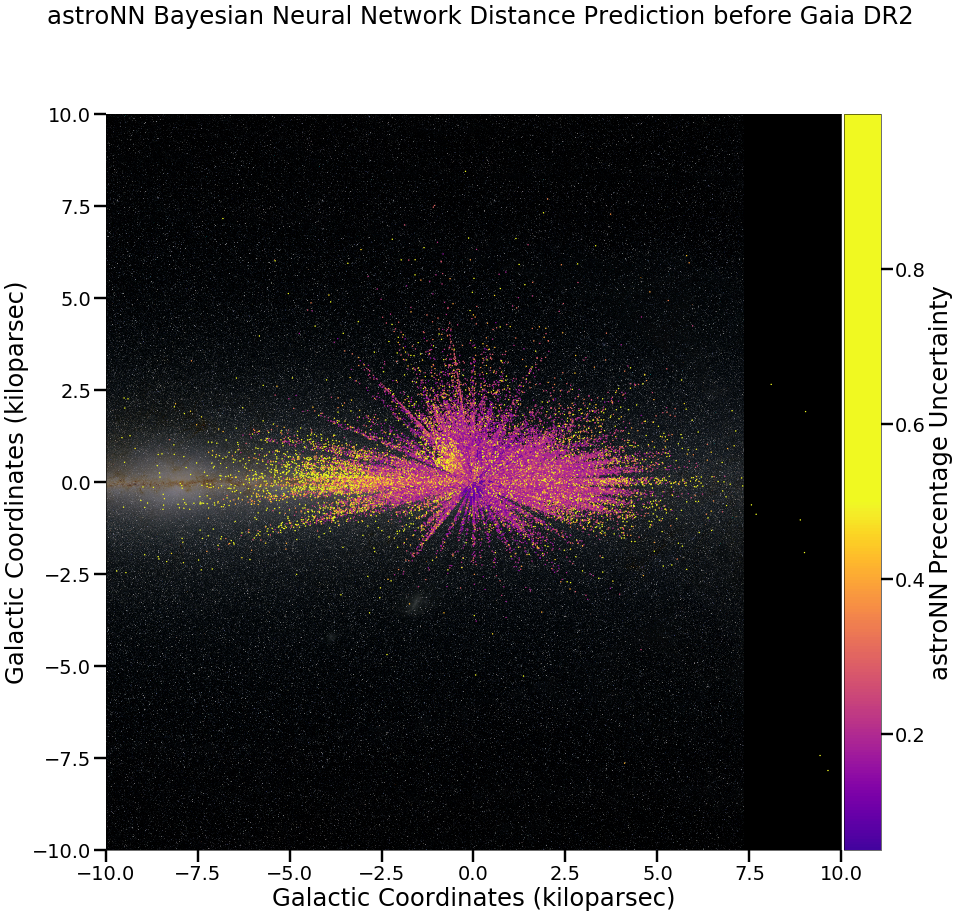

In [4]:
from astroNN.gaia import fakemag_to_pc
from mw_plot import MWPlot
from astroNN.gaia import tgas_load
from astropy import units as  u
import astropy.coordinates as apycoords
from astropy.io import fits
import h5py
import numpy as np

pred = np.load('_astronn_dist.npy')
pred_err = np.load('_astronn_dist_err.npy')

h5f = h5py.File(f'apogee4gaia_dr2.h5', 'r')
adpc = np.array(h5f['apogee_dist'])
apogeeRA = np.array(h5f['RA'])
apogeeDEC = np.array(h5f['DEC'])
adpc_err = np.array(h5f['apogee_dist_err'])

Kmag = np.array(h5f['K'], dtype=np.float32)
astronn_pc, astronn_pc_err = fakemag_to_pc(pred[:, 0], Kmag, pred_err[:, 0])
astroNN_uncerpre = astronn_pc_err.value / (astronn_pc.value + 1e-8)
good_idx_astroNN = [(astroNN_uncerpre < 1.0) & (astronn_pc.value > 0.)]

# use astropy coordinates tranformation
c = apycoords.SkyCoord(ra=apogeeRA[good_idx_astroNN]*u.deg, dec=apogeeDEC[good_idx_astroNN]*u.deg, 
                       distance=astronn_pc[good_idx_astroNN], frame='icrs')

# setup a MWPlot instance
# use galactic coordinates because Gaia observations are from Earth
plot_instance = MWPlot(mode='edge-on', radius=10*u.kpc, unit=u.kpc, coord='galactic')

plot_instance.s = 1.0  # make the scatter points bigger
plot_instance.imalpha = .5
plot_instance.dpi = 50 # increase this to increase image quality
plot_instance.cmap = 'plasma'
plot_instance.clim = (0, 0.5)
# plot, need to flip the sign of x because astropy is left-handed but mw_plot is right-handed
plot_instance.mw_plot(-c.galactic.cartesian.x, c.galactic.cartesian.z, [astroNN_uncerpre[good_idx_astroNN], 'astroNN Precentage Uncertainty'],
                   'astroNN Bayesian Neural Network Distance Prediction before Gaia DR2')

# Save the figure
# plot_instance.savefig(file='gaia_dr2_astronn_edgeon.png')